In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import geobr
import numpy as np

In [45]:
dados_participantes = pd.read_csv("DADOS/participantes.csv", sep=";", encoding="latin1")
dados_resultados = pd.read_csv("DADOS/resultados.csv", sep=";", encoding="latin1")

In [46]:

dados_participantes = dados_participantes.drop(['NU_INSCRICAO', 'NU_ANO', 'TP_ESTADO_CIVIL', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q008'], axis=1)
dados_resultados = dados_resultados.drop(['NU_SEQUENCIAL', 'NU_ANO', 'CO_ESCOLA', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'CO_MUNICIPIO_PROVA',
       'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'CO_MUNICIPIO_ESC', 'TP_PRESENCA_CN',
       'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'CO_PROVA_CN',
       'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT','TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH',
       'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT','TP_LINGUA', 'TP_STATUS_REDACAO','TX_GABARITO_CN', 'TX_GABARITO_CH','TX_GABARITO_LC', 'TX_GABARITO_MT'], axis=1)


In [47]:
dados_resultados = dados_resultados.dropna()


In [48]:
dados_resultados = dados_resultados.rename(columns={"SG_UF_PROVA" : "Estado"})

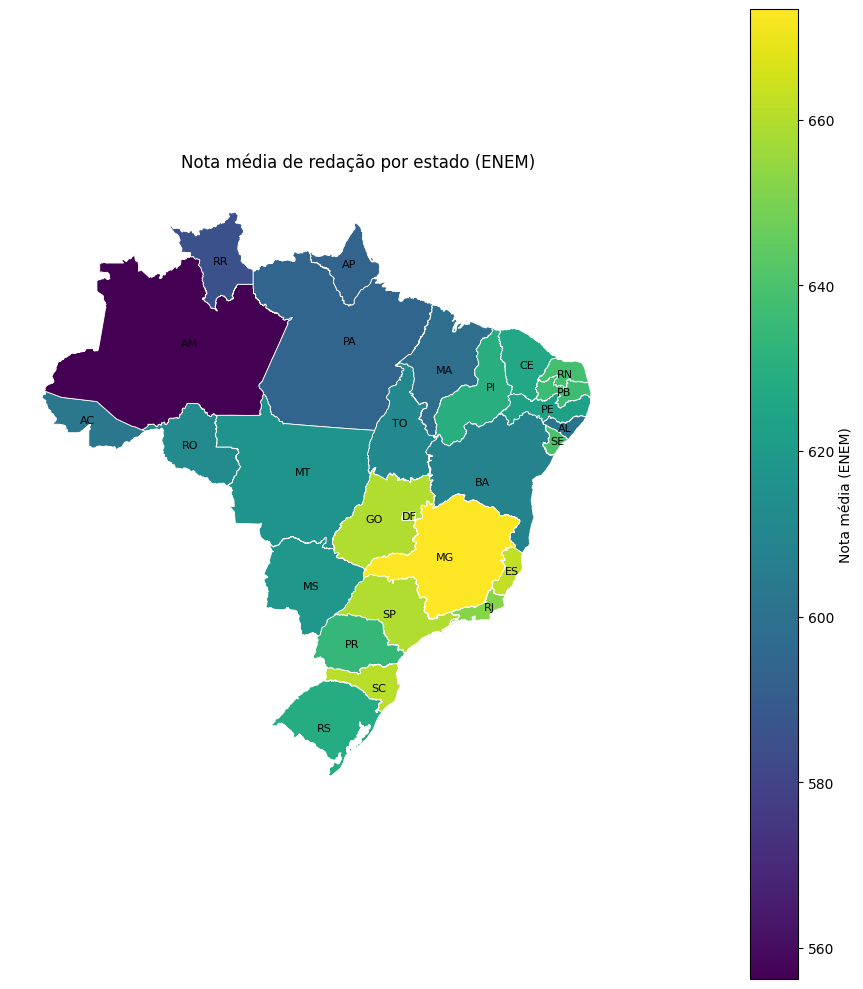

In [49]:
# usar apenas a nota de redação
dados_resultados['nota_media'] = dados_resultados['NU_NOTA_REDACAO']

# manter apenas quem tem UF e nota de redação
dados_limpos = dados_resultados.dropna(subset=['Estado', 'nota_media'])

# agregar por UF
media_uf = (dados_limpos.groupby('Estado', as_index=False)['nota_media']
                      .mean()
                      .rename(columns={'nota_media': 'nota_media_uf'}))

# --- 4) Baixar as UFs do Brasil com geobr ---
gdf_uf = geobr.read_state(year=2020, simplified=True)[['abbrev_state', 'geometry']]
gdf_uf = gdf_uf.rename(columns={'abbrev_state': 'Estado'})

# --- 5) Juntar e plotar ---
mapa = gdf_uf.merge(media_uf, on='Estado', how='left')

fig, ax = plt.subplots(figsize=(9, 10))
mapa.plot(
    column='nota_media_uf',
    ax=ax,
    legend=True,
    legend_kwds={'label': 'Nota média (ENEM)'},
    edgecolor='white',
    linewidth=0.6
)
ax.set_title('Nota média de redação por estado (ENEM)', pad=12)
ax.axis('off')

# Anotar siglas no centroide representativo (opcional)
for x, y, label in zip(mapa.geometry.representative_point().x,
                       mapa.geometry.representative_point().y,
                       mapa['Estado']):
    ax.text(x, y, label, ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()
fig.savefig('mapas_media_enem_redacao.png', dpi=300, bbox_inches='tight')

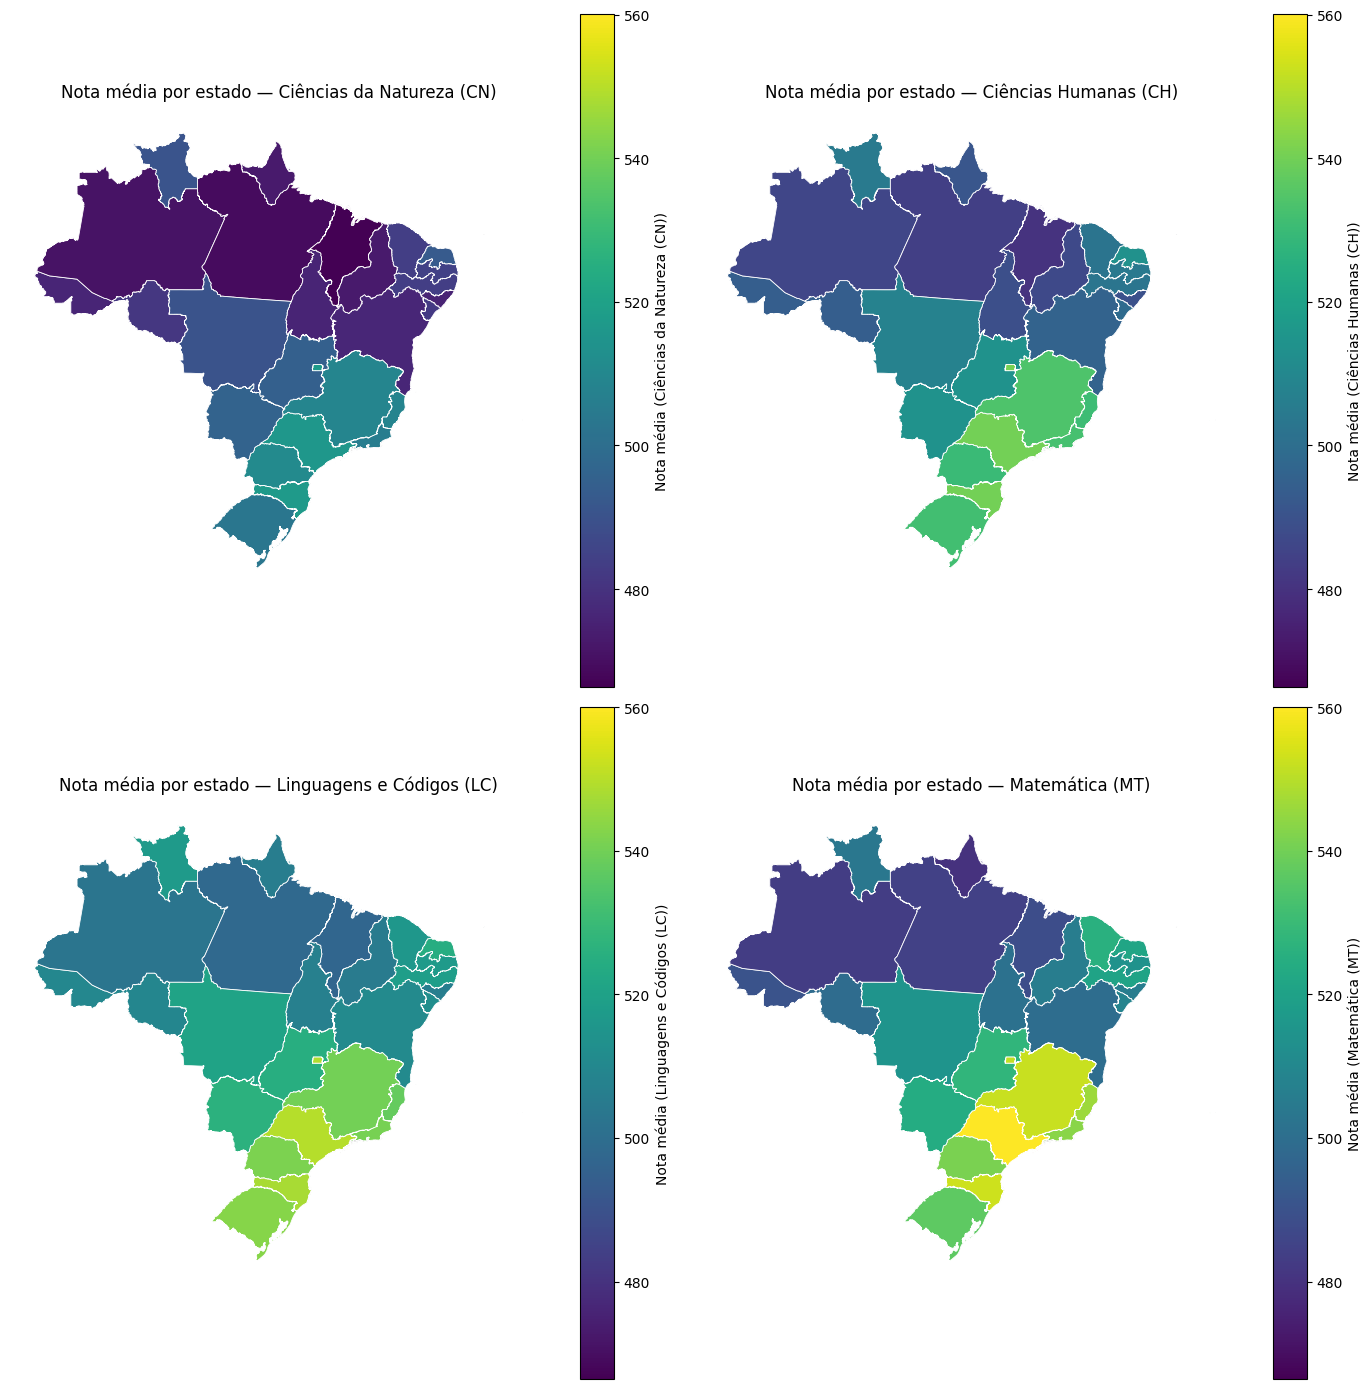

In [50]:
areas = {
    'NU_NOTA_CN': 'Ciências da Natureza (CN)',
    'NU_NOTA_CH': 'Ciências Humanas (CH)',
    'NU_NOTA_LC': 'Linguagens e Códigos (LC)',
    'NU_NOTA_MT': 'Matemática (MT)',
}
notas_cols = list(areas.keys())

# garantir que as notas são numéricas
for c in notas_cols:
    dados_resultados[c] = pd.to_numeric(dados_resultados[c], errors='coerce')

# (opcional) tratar zeros como ausentes (evita distorção por provas não feitas)
for c in notas_cols:
    dados_resultados.loc[dados_resultados[c] <= 0, c] = np.nan

# --- 2) Média por UF para cada área ---
validos = dados_resultados['Estado'].notna()
medias_uf = (dados_resultados.loc[validos]
             .groupby('Estado')[notas_cols]
             .mean()
             .reset_index())

# --- 3) Geometria das UFs ---
gdf_uf = geobr.read_state(year=2020, simplified=True)[['abbrev_state', 'geometry']]
gdf_uf = gdf_uf.rename(columns={'abbrev_state': 'Estado'})

# juntar
mapa = gdf_uf.merge(medias_uf, on='Estado', how='left')

# --- 4) Plot: 4 mapas lado a lado, mesma escala para facilitar comparação ---
vmin = medias_uf[notas_cols].min().min()
vmax = medias_uf[notas_cols].max().max()

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

for ax, col in zip(axes.flat, notas_cols):
    mapa.plot(
        column=col, ax=ax, edgecolor='white', linewidth=0.6,
        legend=True, legend_kwds={'label': f'Nota média ({areas[col]})'},
        vmin=vmin, vmax=vmax,  # mesma escala nos 4 mapas
        # (opcional) destacar faltantes:
        # missing_kwds={'color': 'lightgrey', 'hatch': '///', 'label': 'Sem dados'}
    )
    ax.set_title(f'Nota média por estado — {areas[col]}', pad=10)
    ax.axis('off')

plt.tight_layout()
plt.show()
fig.savefig('mapas_media_enem_por_area.png', dpi=300, bbox_inches='tight')

In [51]:
dados_participantes.columns

Index(['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_ENSINO',
       'IN_TREINEIRO', 'Q006', 'Q007', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
       'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
       'Q023'],
      dtype='object')